In [1]:
import torch
import os
import torch.nn.functional as F
from torch_geometric.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST

In [2]:
class GNN_MNIST(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GNN_MNIST, self).__init__()
        self.conv1 = GCNConv(num_node_features, 32)
        self.conv2 = GCNConv(32, 64)
        self.conv3 = GCNConv(64, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [3]:
class MNISTGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MNISTGraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [f'data_{i}.pt' for i in range(60000)]

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'), weights_only=False)
        return data

In [4]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating"):
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

c:\Program Files\Python313\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Using device: cuda
Trained model weights loaded successfully.


Evaluating: 100%|██████████| 94/94 [00:08<00:00, 10.55it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      1175
           1       0.89      0.96      0.92      1322
           2       0.54      0.69      0.61      1174
           3       0.44      0.36      0.40      1219
           4       0.75      0.70      0.73      1176
           5       0.51      0.38      0.43      1104
           6       0.76      0.77      0.76      1177
           7       0.78      0.73      0.75      1299
           8       0.59      0.44      0.51      1160
           9       0.61      0.79      0.69      1194

    accuracy                           0.67     12000
   macro avg       0.66      0.66      0.65     12000
weighted avg       0.66      0.67      0.66     12000


Confusion Matrix:
[[ 946    1   20    5    8   83   67    0   37    8]
 [   0 1275   10    8    0    2    2    7   15    3]
 [  51    8  810  127   23   38   84    7   24    2]
 [  24   32  423  440   20   71   42   

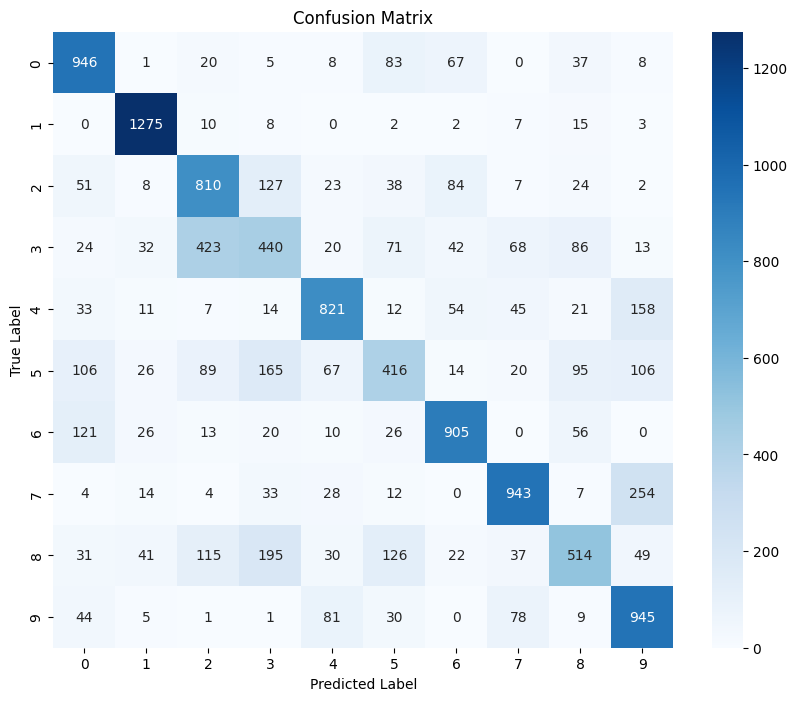

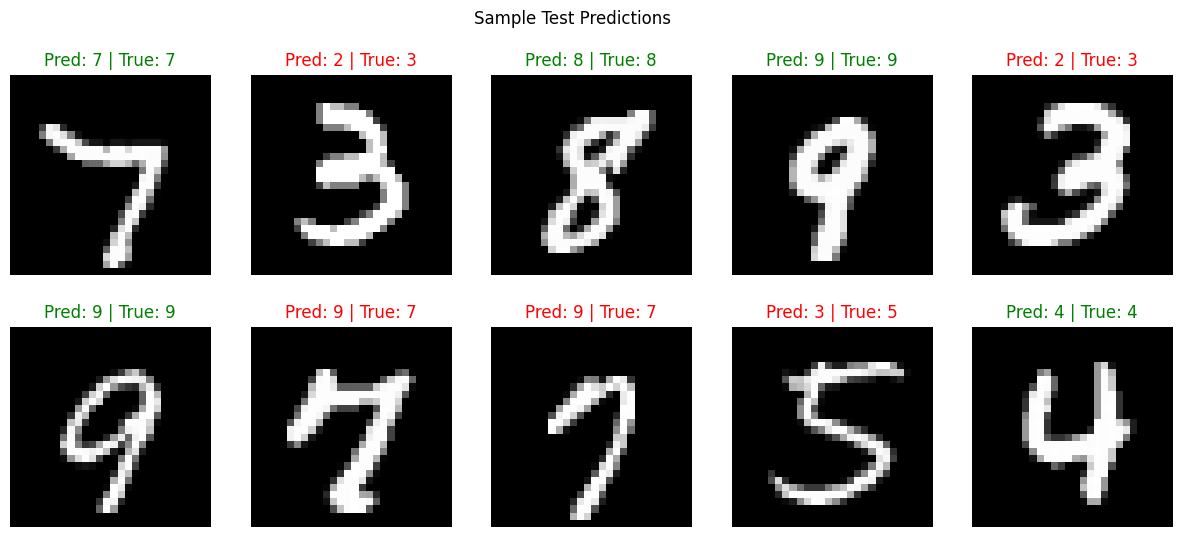

In [7]:
if __name__ == '__main__':
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load the full dataset to get the correct test split
    full_dataset = MNISTGraphDataset(root='./mnist_graphs')
    
    # We use the same random_state to ensure we get the exact same test set
    train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)
    test_dataset = full_dataset[test_indices]
    
    # Create DataLoader for the test set
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Initialize the model architecture
    model = GNN_MNIST(num_node_features=3, num_classes=10).to(device)
    
    # Load the saved weights
    model_path = 'gnn_mnist_model.pth'
    if not os.path.exists(model_path):
        print(f"Model file not found at {model_path}. Please run train_gnn.py first to save the model.")
    else:
        model.load_state_dict(torch.load(model_path))
        print("Trained model weights loaded successfully.")

        # Evaluate the model
        predictions, true_labels = evaluate_model(model, test_loader, device)
        
        # --- Performance Metrics ---
        # 1. Classification Report (Precision, Recall, F1-Score)
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions))
        
        # 2. Confusion Matrix
        print("\nConfusion Matrix:")
        conf_matrix = confusion_matrix(true_labels, predictions)
        print(conf_matrix)
        
        # --- Visualization ---
        # Plotting the Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        # Visualize some predictions
        original_mnist_test = MNIST(root='./', train=True, download=True)
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()

        for i in range(10):
            original_idx = test_indices[i]
            original_image, true_label_val = original_mnist_test[original_idx]
            predicted_label_val = predictions[i]
            
            axes[i].imshow(original_image, cmap='gray')
            axes[i].set_title(f"Pred: {predicted_label_val} | True: {true_label_val}", 
                              color='green' if predicted_label_val == true_label_val else 'red')
            axes[i].axis('off')
            
        plt.suptitle('Sample Test Predictions')
        plt.show()